In [2]:
pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

from sklearn.linear_model import LinearRegression
import math
np.random.seed(10)

# Estimating true causal effect

## Continuous linear models

1. For the following linear model, what is the true causal effect of $X$ on $Y$?

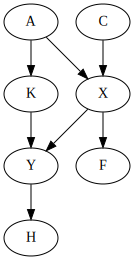

In [4]:
fd_cont = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.7, size=n_samples),
    "A": lambda n_samples: np.random.binomial(n=1, p=0.2, size=n_samples),
    "K": lambda A, n_samples: A + .1 * np.random.normal(),
    "X": discrete_model(["C", "A"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.7, 0.3),
        (1, 0): (0.5, 0.5),
        (1, 1): (0.8, 0.2),
        }),  
    "F": lambda X, n_samples: 3 * X + .8 * np.random.normal(),
    "Y": lambda K, X, n_samples: 2 * K - X + .2 * np.random.normal(),
    "H": lambda Y, n_samples: .5 * Y + .1 * np.random.normal()
})

fd_cont.cgm.draw()

The true causal effect is -1

In below, we estimate this effect using regression

In [5]:
# generating a sample
data_df = fd_cont.sample(n_samples=100000)
data_df.head()

,C,A,K,X,F,Y,H
0,0,0,-0.175624,1.0,2.714837,-1.633054,-0.829532
1,1,0,-0.175624,1.0,2.714837,-1.633054,-0.829532
2,1,0,-0.175624,0.0,-0.285163,-0.633054,-0.329532
3,0,0,-0.175624,1.0,2.714837,-1.633054,-0.829532
4,1,1,0.824376,1.0,2.714837,0.366946,0.170468


Your answer:

In [6]:
regressor = LinearRegression()
regressor.fit(data_df[['X', 'A']].values, data_df['Y'].values)
regressor.coef_[0]

-1.0000000000000109

Let us modify the model to simulate a randomized experiment and identify the true causal effect? *Hint:* to simulate a randomized experiment, we can change the function for $X$ as follows `"X": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples)`. After that, we can calculate ATE between $X$ and $Y$ as follows: $ATE = E[Y|X=1] - E[Y|X=0]$.

Now the treatment assignment is random, as required in randomized experiments.

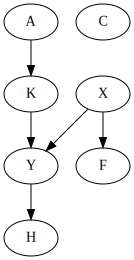

In [7]:
# SOLUTION
fd_cont_re = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.7, size=n_samples),
    "A": lambda n_samples: np.random.binomial(n=1, p=0.2, size=n_samples),
    "K": lambda A, n_samples: A + .1 * np.random.normal(),
    "X": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "F": lambda X, n_samples: 3 * X + .8 * np.random.normal(),
    "Y": lambda K, X, n_samples: 2 * K - X + .2 * np.random.normal(),
    "H": lambda Y, n_samples: .5 * Y + .1 * np.random.normal()
})

fd_cont_re.cgm.draw()

In [8]:
# generating a sample
data_df = fd_cont_re.sample(n_samples=100000)
data_df.head()

,C,A,X,K,F,Y,H
0,0,0,0,-0.052399,0.018442,-0.121596,-0.105469
1,1,1,1,0.947601,3.018442,0.878404,0.394531
2,1,0,1,-0.052399,3.018442,-1.121596,-0.605469
3,1,0,0,-0.052399,0.018442,-0.121596,-0.105469
4,1,1,1,0.947601,3.018442,0.878404,0.394531


In [9]:
# average treatment effect
ate = data_df[data_df['X'] == 1]['Y'].mean() - data_df[data_df['X'] == 0]['Y'].mean()
print("Average Treatment Effect (ATE): ", ate)


Average Treatment Effect (ATE):  -0.9943198785799694


In [10]:
math.isclose(ate, -1, rel_tol=1e-02)

True

The obtained value should be close to the true ATE: -1.


2. Will increasing/decreasing the sample size affect your estimation accuracy?

Your solution:

In [11]:
# generating a sample
data_df = fd_cont_re.sample(n_samples=10000000)
data_df.head()

,C,A,X,K,F,Y,H
0,1,0,0,-0.034032,-0.554418,-0.201314,-0.171606
1,1,1,0,0.965968,-0.554418,1.798686,0.828394
2,0,0,1,-0.034032,2.445582,-1.201314,-0.671606
3,1,1,0,0.965968,-0.554418,1.798686,0.828394
4,1,1,0,0.965968,-0.554418,1.798686,0.828394


In [12]:
# average treatment effect
ate = data_df[data_df['X'] == 1]['Y'].mean() - data_df[data_df['X'] == 0]['Y'].mean()
print("Average Treatment Effect (ATE): ", ate)


Average Treatment Effect (ATE):  -1.000161940565334


In [13]:
math.isclose(ate, -1, rel_tol=1e-04)

False

I conclude that increasing sample size makes estimation more accurate (increase from 1e-02 to 1e-04)

Let us now try a naive estimation. That is let us calculate the same value $E[Y|X=1] - E[Y|X=0]$, but from a sample from the original (non modified!) model. 

In [14]:
# modified model
df = fd_cont_re.sample(n_samples=100000)
ate = df[df['X'] == 1]['Y'].mean() - df[df['X'] == 0]['Y'].mean()
print("Average Treatment Effect (ATE): ", ate)


Average Treatment Effect (ATE):  -1.0025128288492515


In [15]:
# original model
df = fd_cont.sample(n_samples=100000)
ate = df[df['X'] == 1]['Y'].mean() - df[df['X'] == 0]['Y'].mean()
print("Average Treatment Effect (ATE): ", ate)


Average Treatment Effect (ATE):  -1.5081149041407331


The deviation from the true ATE is now almost 50%. This is due to the fact that data sampled from the original model has the confounders (common causes of $X$ and $Y$).

## Discrete models

1. For the following discrete model `fd_discr`, estimate the true causal effect of $X$ on $Y$? *Simulate a randomized experiment as in the previous example.*
2. Estimate causal effect using a naive approach: for a sample from the original `fd_cont` model (not the modified model!), calculate association between $X$ and $Y$: $E[Y|X=1] - E[Y|X=0]$. 
3. Estimate causal effect with backdoor adjustment (conditioning on confounder): $ATE = E_C[E[Y|X=1, C] - E[Y|X=0,C]]$
4. Which estimation is close to the true value of $\approx -0.30$? Why?
5. Will increasing/decreasing sample size affect your estimation accuracy?

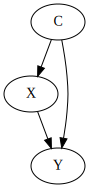

In [16]:
fd_discr = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "X": discrete_model(["C"], {(0,): (0.1,0.9), (1,): (0.9,0.1)}),
    "Y": discrete_model(["X", "C"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.5, 0.5),
        (1, 0): (0.9, 0.1), 
        (1, 1): (0.3, 0.7),
    }),
})

fd_discr.cgm.draw()

Your solution

### 1

In [17]:
df = fd_discr.sample(n_samples=100000)

In [18]:
# estimate causal effect using average treatment effect
ate = df[df['X'] == 1]['Y'].mean() - df[df['X'] == 0]['Y'].mean()
print("Average Treatment Effect (ATE): ", ate)


Average Treatment Effect (ATE):  -0.37751079399324183


### 2

In [19]:
# sample from the original (unmodified) model
df = fd_cont.sample(n_samples=100000)

In [20]:
# estimate causal effect using average treatment effect
ate = df[df['X'] == 1]['Y'].mean() - df[df['X'] == 0]['Y'].mean()
print("Average Treatment Effect (ATE): ", ate)


Average Treatment Effect (ATE):  -1.4952951581363019


Again, there is discrepancy from the actual causal effect as discussed before.

### 3-4

In [21]:
df = fd_discr.sample(n_samples=100000)

In [22]:
# calculate size of sub-populations
n0 = df[df['C'] == 0].shape[0] / df.shape[0]
n1 = df[df['C'] == 1].shape[0] / df.shape[0]
print("proportion of size of subgroup C = 0: ", n0)
print("proportion of size of subgroup C = 1: ", n1)
print("total size of population: ", df.shape[0])

proportion of size of subgroup C = 0:  0.499
proportion of size of subgroup C = 1:  0.501
total size of population:  100000


In [23]:
# when X = 1
E_Y_cond_X_1_C_0 = df.query('X == 1 and C == 0')['Y'].mean()
E_Y_cond_X_1_C_1 = df.query('X == 1 and C == 1')['Y'].mean()
t1 = n0 * E_Y_cond_X_1_C_0  + n1 * E_Y_cond_X_1_C_1

# when X = 0
E_Y_cond_X_0_C_0 = df.query('X == 0 and C == 0')['Y'].mean()
E_Y_cond_X_0_C_1 = df.query('X == 0 and C == 1')['Y'].mean()
t2 = n0 * E_Y_cond_X_0_C_0 + n1 * E_Y_cond_X_0_C_1

# calculate ATE
ate = t1 - t2
print("Average Treatment Effect (ATE): ", ate)

Average Treatment Effect (ATE):  -0.30667089868896136


In [24]:
math.isclose(ate, -0.30, rel_tol=1e-02)

False

The estimation whith backdoor adjustment is more accurate and closer to the true value (-0.30), while the primary estimation of the discrete model yield the estimation value of -0.38, which is less accurate.
The backdoor adjustment leads to better estimation, as C acts a confounder and affects both Y and X. When we condition on values C can take (in this case 0 and 1), we neutralize the effect of this confounder, hence a more precise estimation.

### 5

In [25]:
# check the effect of sample size 
## increasing
dfi = fd_discr.sample(n_samples=10000000)
## decreasing
dfd = fd_discr.sample(n_samples=1000)

In [26]:
## increasing case
# calculate size of sub-populations
n0 = dfi[dfi['C'] == 0].shape[0] / dfi.shape[0]
n1 = dfi[dfi['C'] == 1].shape[0] / dfi.shape[0]
print("proportion of size of subgroup C = 0: ", n0)
print("proportion of size of subgroup C = 1: ", n1)
print("total size of population: ", dfi.shape[0])


# when X = 1
E_Y_cond_X_1_C_0 = dfi.query('X == 1 and C == 0')['Y'].mean()
E_Y_cond_X_1_C_1 = dfi.query('X == 1 and C == 1')['Y'].mean()
t1 = n0 * E_Y_cond_X_1_C_0  + n1 * E_Y_cond_X_1_C_1

# when X = 0
E_Y_cond_X_0_C_0 = dfi.query('X == 0 and C == 0')['Y'].mean()
E_Y_cond_X_0_C_1 = dfi.query('X == 0 and C == 1')['Y'].mean()
t2 = n0 * E_Y_cond_X_0_C_0 + n1 * E_Y_cond_X_0_C_1

# calculate ATE
ate = t1 - t2
print("Average Treatment Effect (ATE): ", ate)


proportion of size of subgroup C = 0:  0.4997595
proportion of size of subgroup C = 1:  0.5002405
total size of population:  10000000
Average Treatment Effect (ATE):  -0.2995481327178937


In [27]:
ate

-0.2995481327178937

In [28]:
math.isclose(ate, -0.30, rel_tol=1e-04)

False

I conclude that increasing sample size makes estimation more accurate (increase from 1e-02 to 1e-04)

In [29]:
## decreasing case
# calculate size of sub-populations
n0 = dfd[dfd['C'] == 0].shape[0] / dfd.shape[0]
n1 = dfd[dfd['C'] == 1].shape[0] / dfd.shape[0]
print("proportion of size of subgroup C = 0: ", n0)
print("proportion of size of subgroup C = 1: ", n1)
print("total size of population: ", dfd.shape[0])


# when X = 1
E_Y_cond_X_1_C_0 = dfd.query('X == 1 and C == 0')['Y'].mean()
E_Y_cond_X_1_C_1 = dfd.query('X == 1 and C == 1')['Y'].mean()
t1 = n0 * E_Y_cond_X_1_C_0  + n1 * E_Y_cond_X_1_C_1

# when X = 0
E_Y_cond_X_0_C_0 = dfd.query('X == 0 and C == 0')['Y'].mean()
E_Y_cond_X_0_C_1 = dfd.query('X == 0 and C == 1')['Y'].mean()
t2 = n0 * E_Y_cond_X_0_C_0 + n1 * E_Y_cond_X_0_C_1

# calculate ATE
ate = t1 - t2
ate


proportion of size of subgroup C = 0:  0.469
proportion of size of subgroup C = 1:  0.531
total size of population:  1000


-0.2538288011270621

In [30]:
math.isclose(ate, -0.30, rel_tol=1e-01)

False

I conclude that decreasing sample size makes estimation very biased.

In [31]:
#np.random.choice([0, 1, 2], size=10000)
#np.random.multinomial(n=1, pvals=[1/3.]*3, size=10000)

Modify the descrete model `fd_discr` such that $C$ would have 3 possible values, name the model `fd_discr_3`. *Note: you can use np.random.choice(), see an example below*

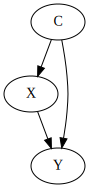

In [32]:
fd_discr_3 = StructuralCausalModel({
    "C": lambda n_samples: np.random.choice([0, 1, 2], size=n_samples),
    "X": discrete_model(["C"], {(0,): (0.1,0.9), (1,): (0.9,0.1), (2,): (0.5,0.5)}),
    "Y": discrete_model(["X", "C"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.5, 0.5),
        (0, 2): (0.3, 0.7),
        (1, 0): (0.9, 0.1), 
        (1, 1): (0.3, 0.7),
        (1, 2): (0.9, 0.1),
    }),
})

fd_discr_3.cgm.draw()

(array([3300.,    0.,    0.,    0.,    0., 3381.,    0.,    0.,    0.,
        3319.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

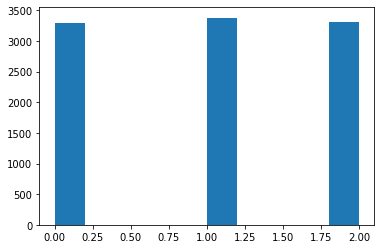

In [33]:
n_samples = 10000
x = np.random.choice([0, 1, 2], size=n_samples)
plt.hist(x)

In [34]:
df = fd_discr_3.sample(n_samples=100000)
df.head()

,C,X,Y
0,1,1.0,1.0
1,0,1.0,0.0
2,1,0.0,0.0
3,0,1.0,0.0
4,0,1.0,0.0


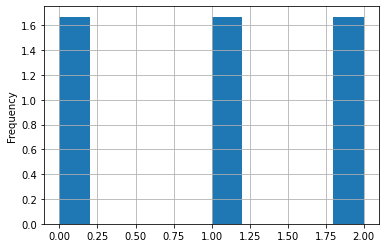

In [35]:
df['C'].plot(
    kind='hist',
    density=True,
    grid=True,
)

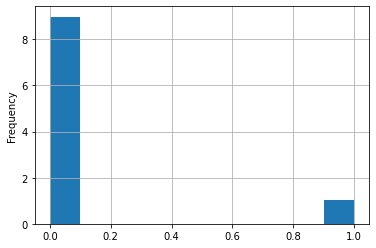

In [36]:
Y_query = df.query('X == 1 and C == 2')['Y']
Y_query.plot(
    kind='hist',
    density=True,
    grid=True,
)

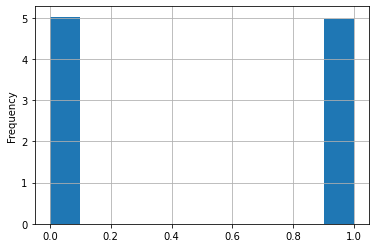

In [37]:
X_query = df.query('C == 2')['X']
X_query.plot(
    kind='hist',
    density=True,
    grid=True,
)

1. For the resulting discrete model `fd_discr_3`, estimate the true causal effect of $X$ on $Y$? *Note: simulate a randomized experiment.*
2. Estimate causal effect without backdoor adjustment (naive way)
3. Estimate causal effect with backdoor adjustment (conditioning on confounder)
4. Will increasing/decreasing sample size affect your estimation accuracy?

### 1

In [38]:
# estimate causal effect using average treatment effect
ate = df[df['X'] == 1]['Y'].mean() - df[df['X'] == 0]['Y'].mean()
print("Average Treatment Effect (ATE): ", ate)


Average Treatment Effect (ATE):  -0.4526348431819509


### 2

In [39]:
# sample from the original (unmodified) model
df = fd_cont.sample(n_samples=100000)

In [40]:
# estimate causal effect using average treatment effect
ate = df[df['X'] == 1]['Y'].mean() - df[df['X'] == 0]['Y'].mean()
print("Average Treatment Effect (ATE): ", ate)


Average Treatment Effect (ATE):  -1.5034266315581066


### 3

In [41]:
df = fd_discr_3.sample(n_samples=100000)

In [42]:
df

,C,X,Y
0,0,1.0,0.0
1,0,0.0,1.0
2,2,0.0,0.0
3,1,0.0,0.0
4,2,0.0,0.0
...,...,...,...
99995,0,1.0,0.0
99996,0,1.0,0.0
99997,1,0.0,1.0
99998,1,0.0,0.0


In [43]:
# calculate size of sub-populations
n0 = df[df['C'] == 0].shape[0] / df.shape[0]
n1 = df[df['C'] == 1].shape[0] / df.shape[0]
n2 = df[df['C'] == 2].shape[0] / df.shape[0]
print("proportion of size of subgroup C = 0: ", n0)
print("proportion of size of subgroup C = 1: ", n1)
print("proportion of size of subgroup C = 2: ", n2)
print("total size of population: ", df.shape[0])


# when X = 1
E_Y_cond_X_1_C_0 = df.query('X == 1 and C == 0')['Y'].mean()
E_Y_cond_X_1_C_1 = df.query('X == 1 and C == 1')['Y'].mean()
E_Y_cond_X_1_C_2 = df.query('X == 1 and C == 2')['Y'].mean()
t1 = n0 * E_Y_cond_X_1_C_0  + n1 * E_Y_cond_X_1_C_1 + n2 * E_Y_cond_X_1_C_2

# when X = 0
E_Y_cond_X_0_C_0 = df.query('X == 0 and C == 0')['Y'].mean()
E_Y_cond_X_0_C_1 = df.query('X == 0 and C == 1')['Y'].mean()
E_Y_cond_X_0_C_2 = df.query('X == 0 and C == 2')['Y'].mean()
t2 = n0 * E_Y_cond_X_0_C_0 + n1 * E_Y_cond_X_0_C_1 + n2 * E_Y_cond_X_0_C_2

# calculate ATE
ate = t1 - t2
print("Average Treatment Effect (ATE): ", ate)



proportion of size of subgroup C = 0:  0.33284
proportion of size of subgroup C = 1:  0.33216
proportion of size of subgroup C = 2:  0.335
total size of population:  100000
Average Treatment Effect (ATE):  -0.4039649651552917


In [44]:
math.isclose(ate, -0.30, rel_tol=1e-02)

False

### 4

In [45]:
# check the effect of sample size 
## increasing
dfi = fd_discr_3.sample(n_samples=10000000)
## decreasing
dfd = fd_discr_3.sample(n_samples=1000)

In [46]:
## increasing case

# calculate size of sub-populations
n0 = dfi[dfi['C'] == 0].shape[0] / dfi.shape[0]
n1 = dfi[dfi['C'] == 1].shape[0] / dfi.shape[0]
n2 = dfi[dfi['C'] == 2].shape[0] / dfi.shape[0]
print("proportion of size of subgroup C = 0: ", n0)
print("proportion of size of subgroup C = 1: ", n1)
print("proportion of size of subgroup C = 2: ", n2)
print("total size of population: ", dfi.shape[0])


# when X = 1
E_Y_cond_X_1_C_0 = dfi.query('X == 1 and C == 0')['Y'].mean()
E_Y_cond_X_1_C_1 = dfi.query('X == 1 and C == 1')['Y'].mean()
E_Y_cond_X_1_C_2 = dfi.query('X == 1 and C == 2')['Y'].mean()
t1 = n0 * E_Y_cond_X_1_C_0  + n1 * E_Y_cond_X_1_C_1 + n2 * E_Y_cond_X_1_C_2

# when X = 0
E_Y_cond_X_0_C_0 = dfi.query('X == 0 and C == 0')['Y'].mean()
E_Y_cond_X_0_C_1 = dfi.query('X == 0 and C == 1')['Y'].mean()
E_Y_cond_X_0_C_2 = dfi.query('X == 0 and C == 2')['Y'].mean()
t2 = n0 * E_Y_cond_X_0_C_0 + n1 * E_Y_cond_X_0_C_1 + n2 * E_Y_cond_X_0_C_2

# calculate ATE
ate = t1 - t2
print("Average Treatment Effect (ATE): ", ate)



proportion of size of subgroup C = 0:  0.3335271
proportion of size of subgroup C = 1:  0.3334616
proportion of size of subgroup C = 2:  0.3330113
total size of population:  10000000
Average Treatment Effect (ATE):  -0.3995546270880756


In [47]:
ate

-0.3995546270880756

In [48]:
math.isclose(ate, -0.30, rel_tol=1e-04)

False

In this case increasing the sample size didn't have a significant improvement on estimation, which is nebulous to me.

In [49]:
## decreasing case

# calculate size of sub-populations
n0 = dfd[dfd['C'] == 0].shape[0] / dfd.shape[0]
n1 = dfd[dfd['C'] == 1].shape[0] / dfd.shape[0]
n2 = dfd[dfd['C'] == 2].shape[0] / dfd.shape[0]
print("proportion of size of subgroup C = 0: ", n0)
print("proportion of size of subgroup C = 1: ", n1)
print("proportion of size of subgroup C = 2: ", n2)
print("total size of population: ", dfd.shape[0])


# when X = 1
E_Y_cond_X_1_C_0 = dfd.query('X == 1 and C == 0')['Y'].mean()
E_Y_cond_X_1_C_1 = dfd.query('X == 1 and C == 1')['Y'].mean()
E_Y_cond_X_1_C_2 = dfd.query('X == 1 and C == 2')['Y'].mean()
t1 = n0 * E_Y_cond_X_1_C_0  + n1 * E_Y_cond_X_1_C_1 + n2 * E_Y_cond_X_1_C_2

# when X = 0
E_Y_cond_X_0_C_0 = dfd.query('X == 0 and C == 0')['Y'].mean()
E_Y_cond_X_0_C_1 = dfd.query('X == 0 and C == 1')['Y'].mean()
E_Y_cond_X_0_C_2 = dfd.query('X == 0 and C == 2')['Y'].mean()
t2 = n0 * E_Y_cond_X_0_C_0 + n1 * E_Y_cond_X_0_C_1 + n2 * E_Y_cond_X_0_C_2

# calculate ATE
ate = t1 - t2
print("Average Treatment Effect (ATE): ", ate)



proportion of size of subgroup C = 0:  0.337
proportion of size of subgroup C = 1:  0.326
proportion of size of subgroup C = 2:  0.337
total size of population:  1000
Average Treatment Effect (ATE):  -0.41114277281929484


In [50]:
math.isclose(ate, -0.30, rel_tol=1e-01)

False

Decreasing worsened the accuracy